In [1]:
#!/usr/bin/env python
"""
Run inference over a dataset using a saved tf model
"""

import tensorflow as tf
import numpy as np
import argparse
import matplotlib.pyplot as plt
import os

IMG_SIZE = 448
INT_IMG_SIZE = (5*IMG_SIZE, 3*IMG_SIZE)

# model_dir = "/home/jovyan/lustre/models/20211210_172840_new_resnet152_bce_jaccard_loss/" # This was run for a long time and got very good validation IoUs but was just over-fitting I think (test IoU was 0.17775108)
model_dir = "/home/jovyan/lustre/models/20211210_112435_new_resnet152_bce_jaccard_loss_augmented/"  # Pretty good looking (0.23580132)
# model_dir = "/home/jovyan/lustre/models/20211209_185631_new_resnet152_bce_jaccard_loss/" # Also good (0.23473369)
# model_dir = "/home/jovyan/lustre/models/20211209_163018_new_resnet152_bce_jaccard_loss_augmented/" # Not so good, not as confident (0.23171362)


2021-12-14 15:37:12.723355: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
from segmentation_models.metrics import iou_score, IOUScore

Segmentation Models: using `tf.keras` framework.


In [3]:
def _parse_batch(record_batch):
    # Create a description of the features
    feature_description = {
        'data': tf.io.FixedLenFeature((IMG_SIZE, IMG_SIZE, 3), tf.float32),
        'mask': tf.io.FixedLenFeature((IMG_SIZE, IMG_SIZE), tf.float32),
    }

    # Parse the input `tf.Example` proto using the dictionary above
    example = tf.io.parse_example(record_batch, feature_description)
    return example['data'], example['mask']


def create_dataset(training_dir, cls_label='positive'):
    import glob
    fl = sorted(glob.glob(f"/{training_dir}/*_{cls_label}.tfrecords"))
    files_ds = tf.data.Dataset.list_files(fl, shuffle=False)
    
    ds = tf.data.TFRecordDataset(files_ds)
    ds = ds.map(lambda x: _parse_batch(x))
    return ds


test_ds = create_dataset("/lustre_scratch/duncanwp/combined_v3_typed_new_composite/tfrecords_test")

2021-12-14 15:37:16.318656: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-14 15:37:16.320011: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-14 15:37:16.568386: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:86:00.0 name: Tesla V100-SXM2-32GB-LS computeCapability: 7.0
coreClock: 1.44GHz coreCount: 80 deviceMemorySize: 31.72GiB deviceMemoryBandwidth: 772.48GiB/s
2021-12-14 15:37:16.571156: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:89:00.0 name: Tesla V100-SXM2-32GB-LS computeCapability: 7.0
coreClock: 1.44GHz coreCount: 80 deviceMemorySize: 31.72GiB deviceMemoryBandwidth: 772.48GiB/s
2021-12-14 15:37:16.571196: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0

In [4]:
model = tf.saved_model.load(model_dir + "model/1")
tf_predictor = model.signatures["serving_default"]


2021-12-14 15:37:42.601947: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-14 15:37:42.602784: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2195205000 Hz
2021-12-14 15:37:44.445842: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2021-12-14 15:37:46.991929: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-12-14 15:37:47.519198: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


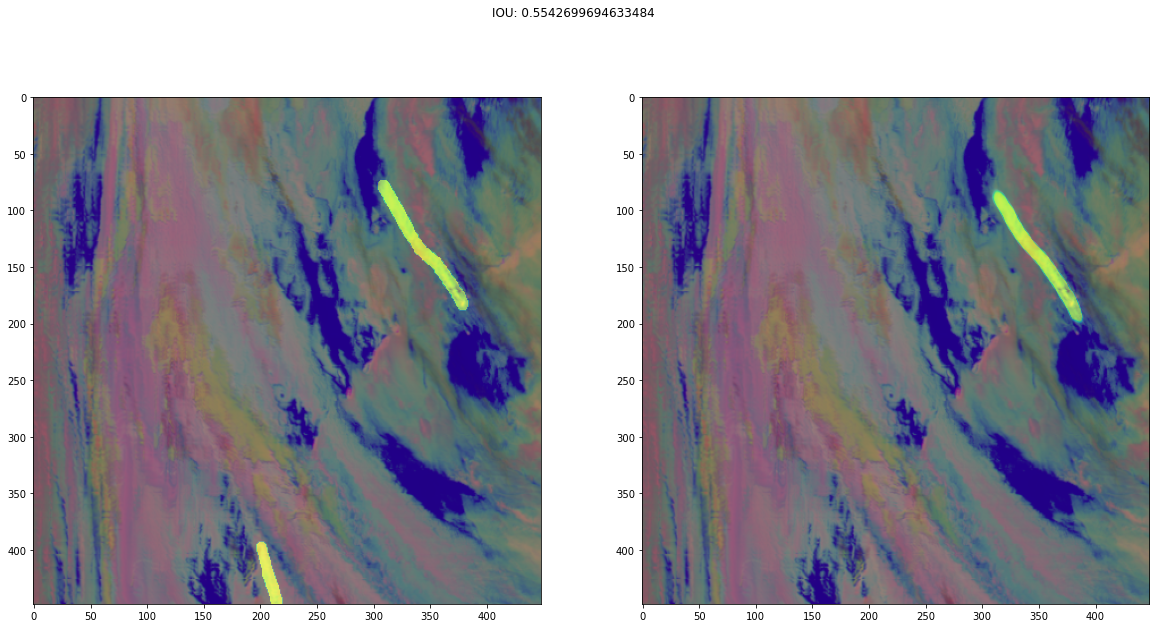

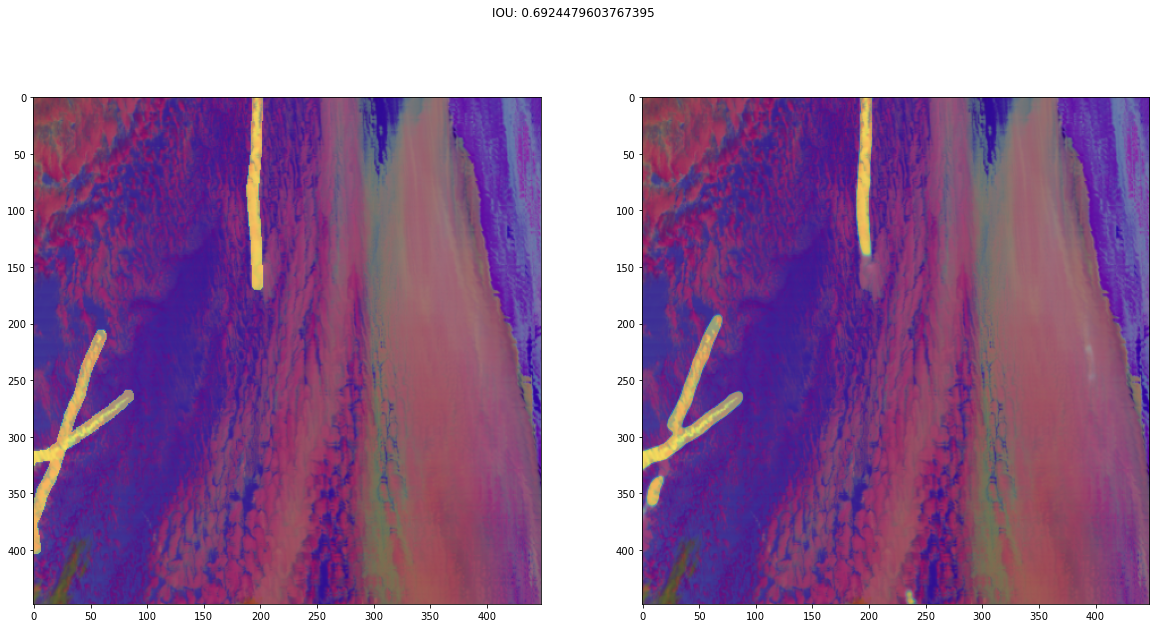

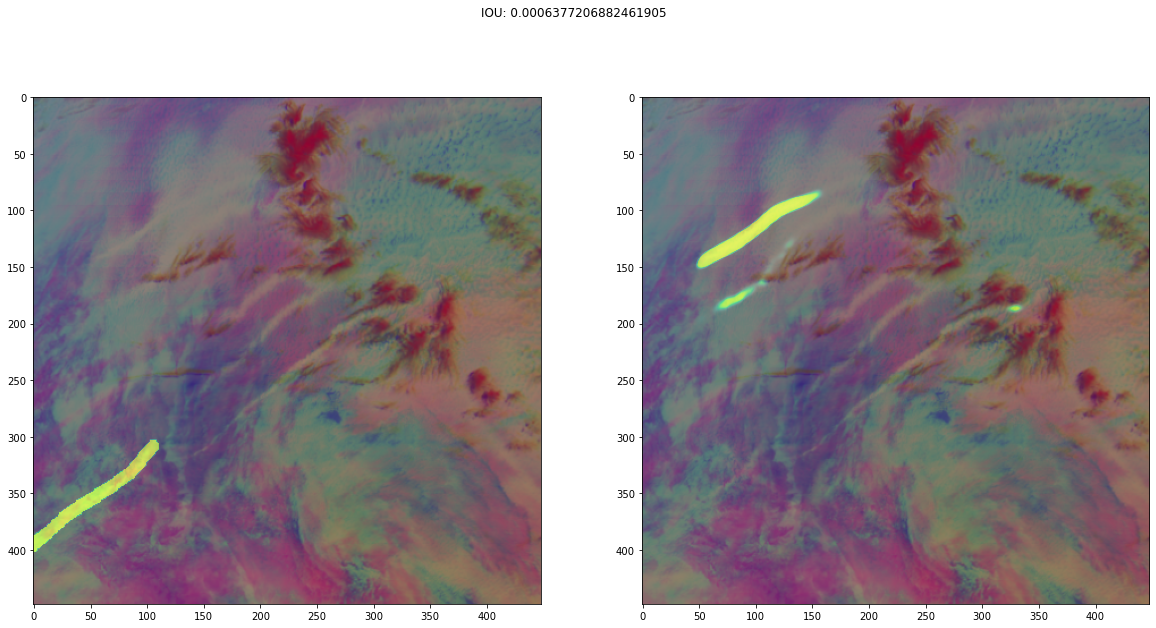

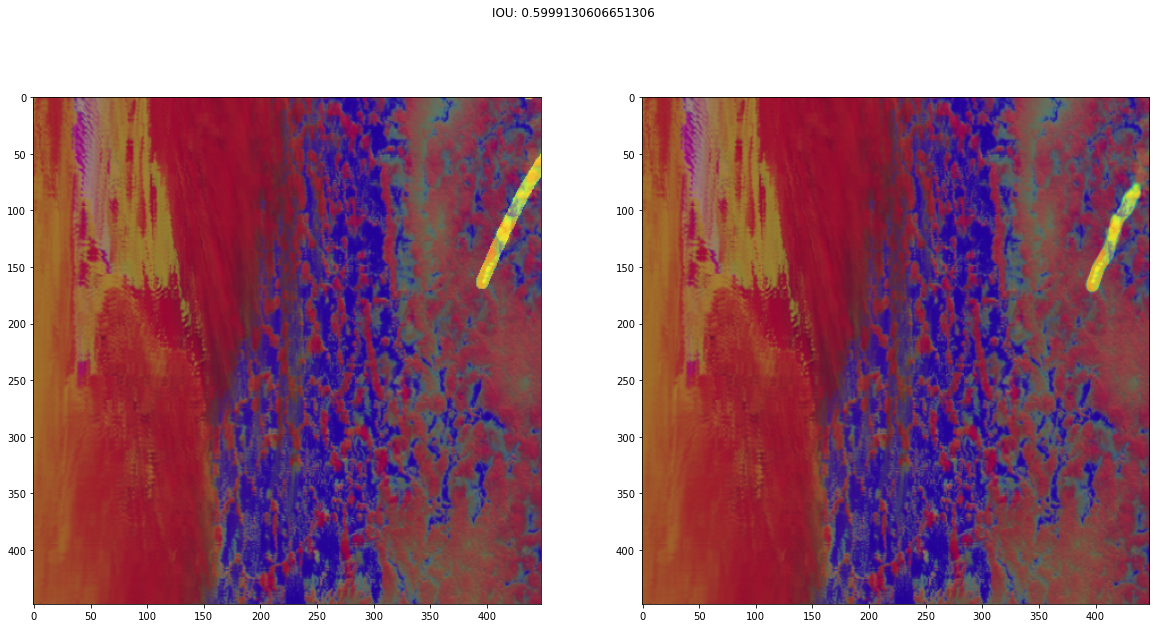

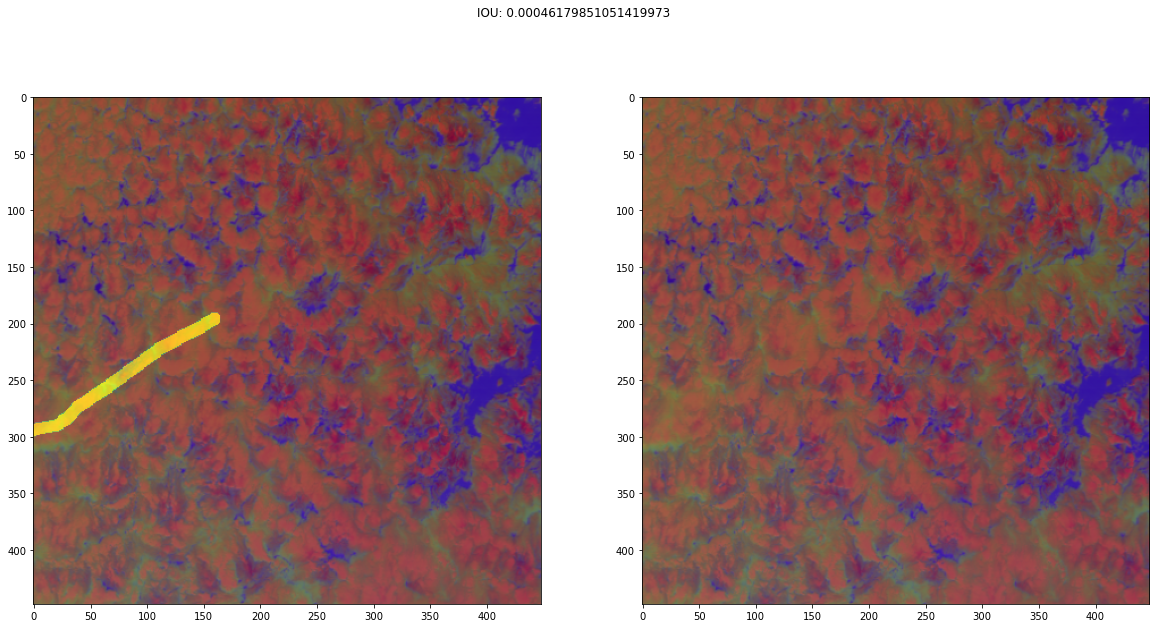

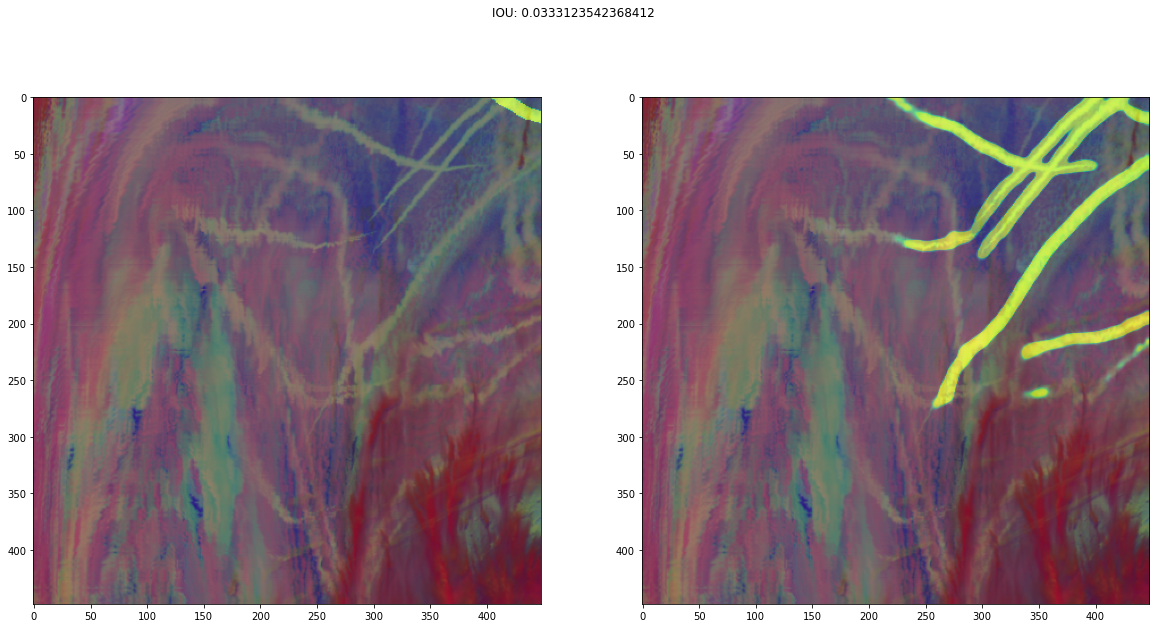

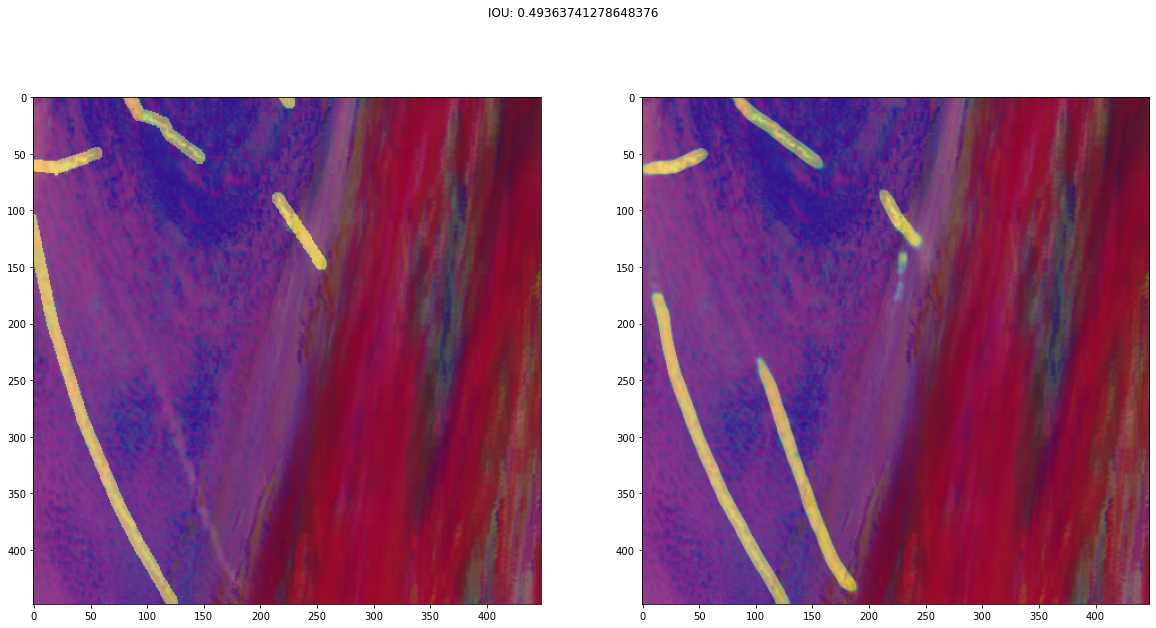

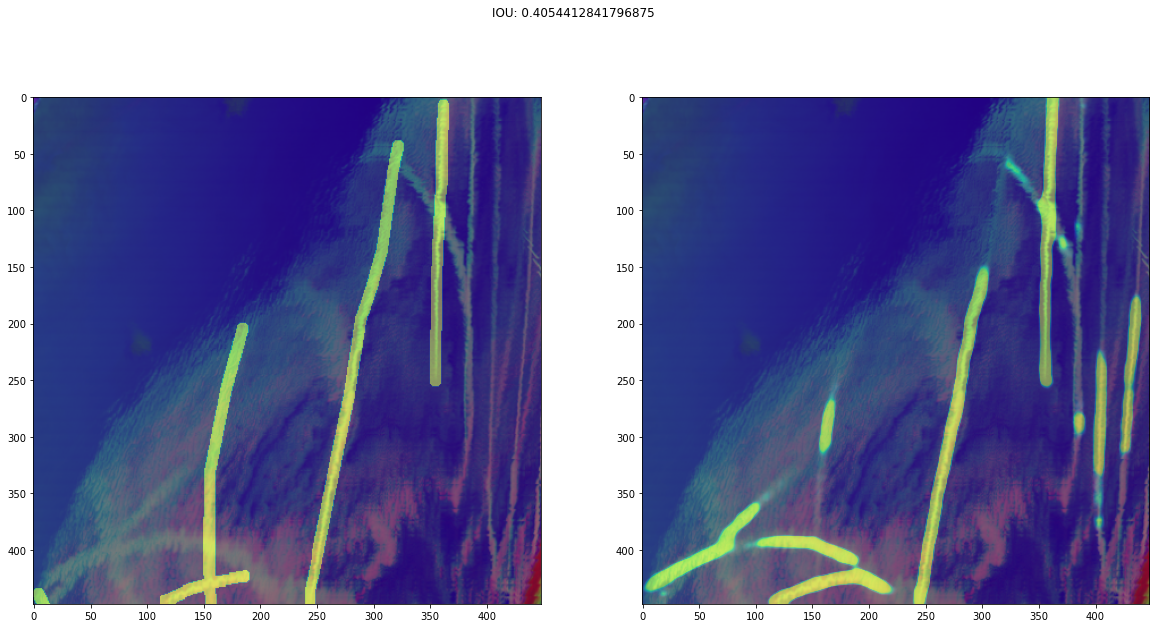

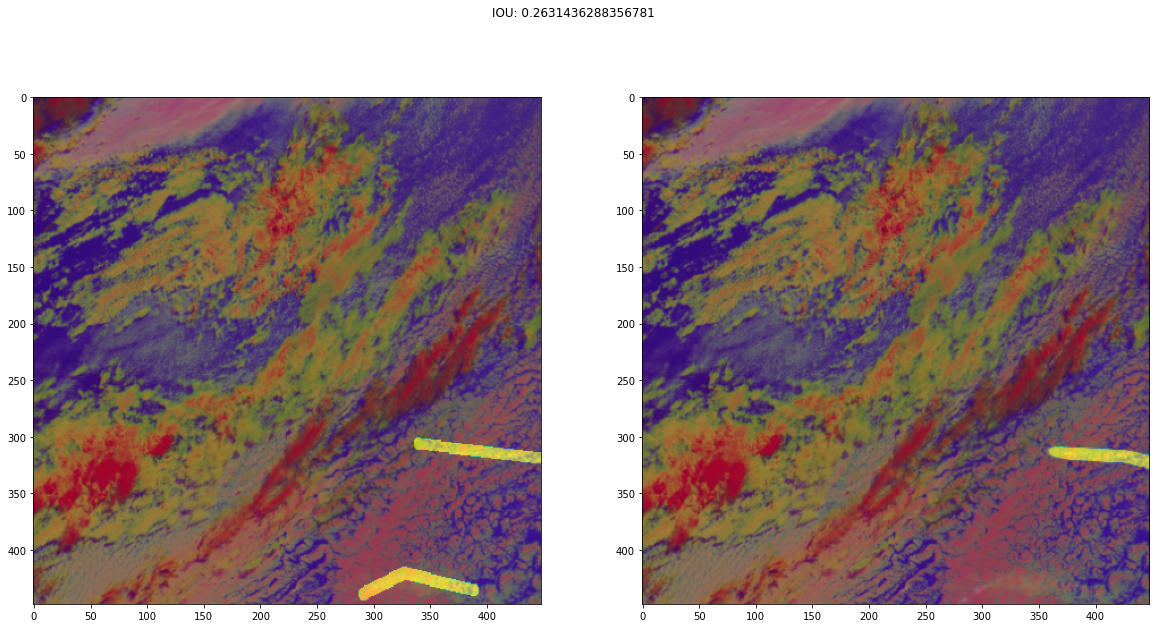

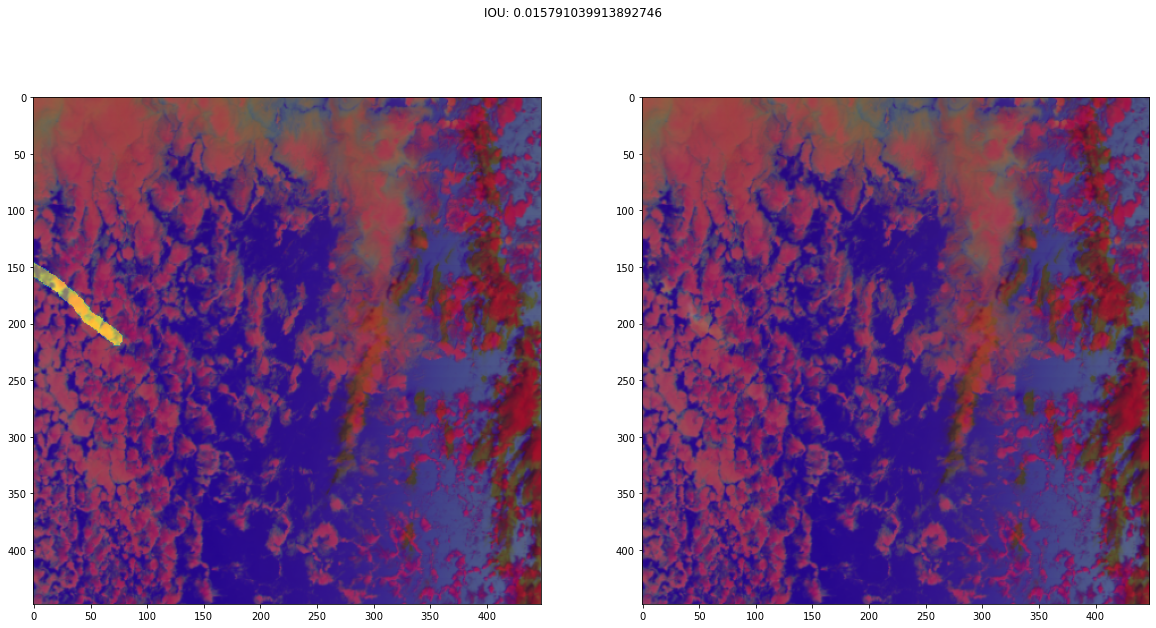

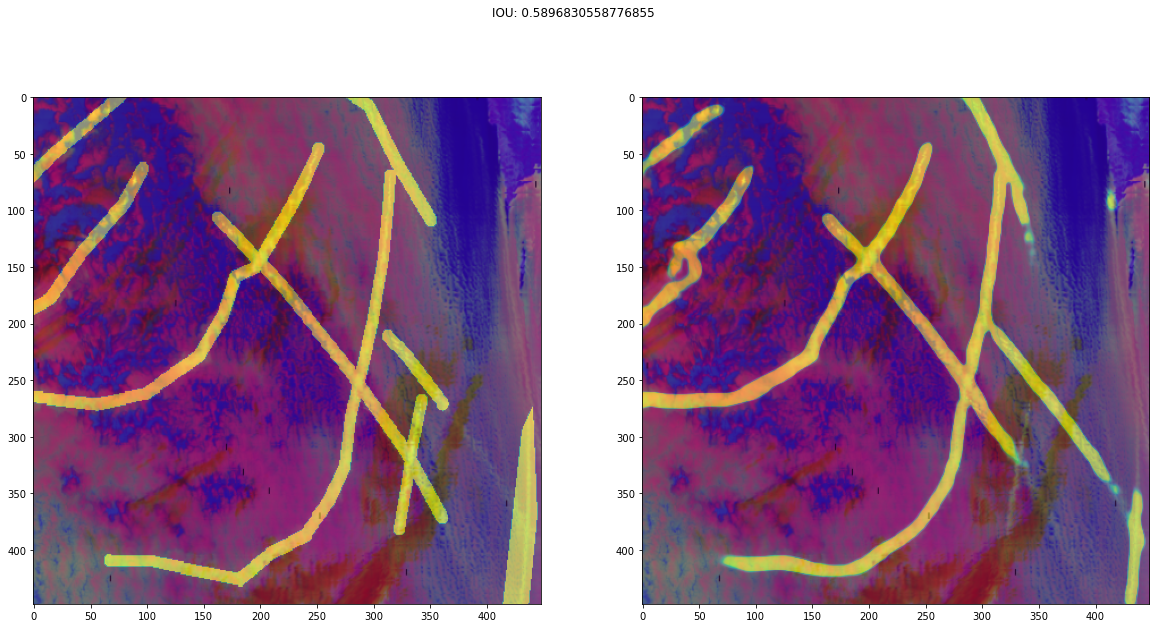

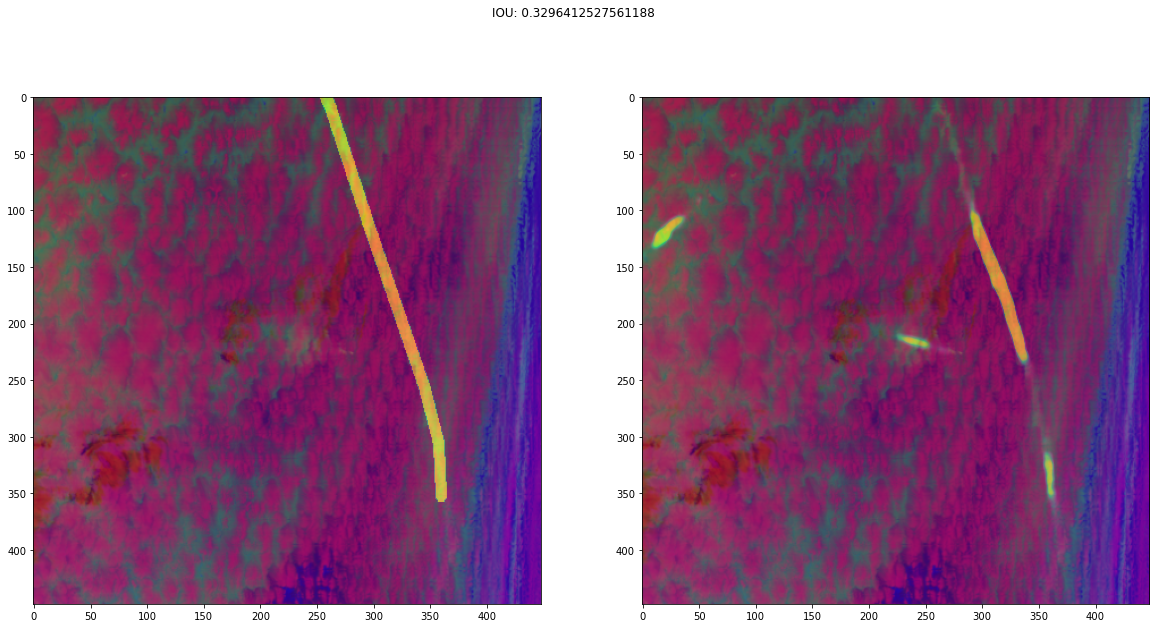

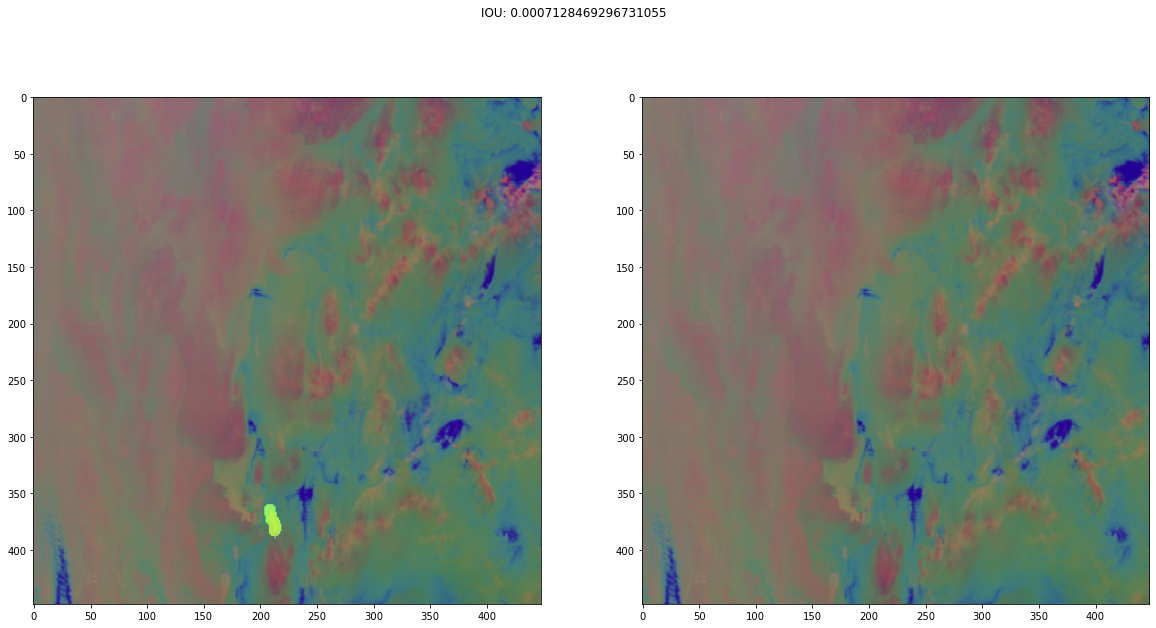

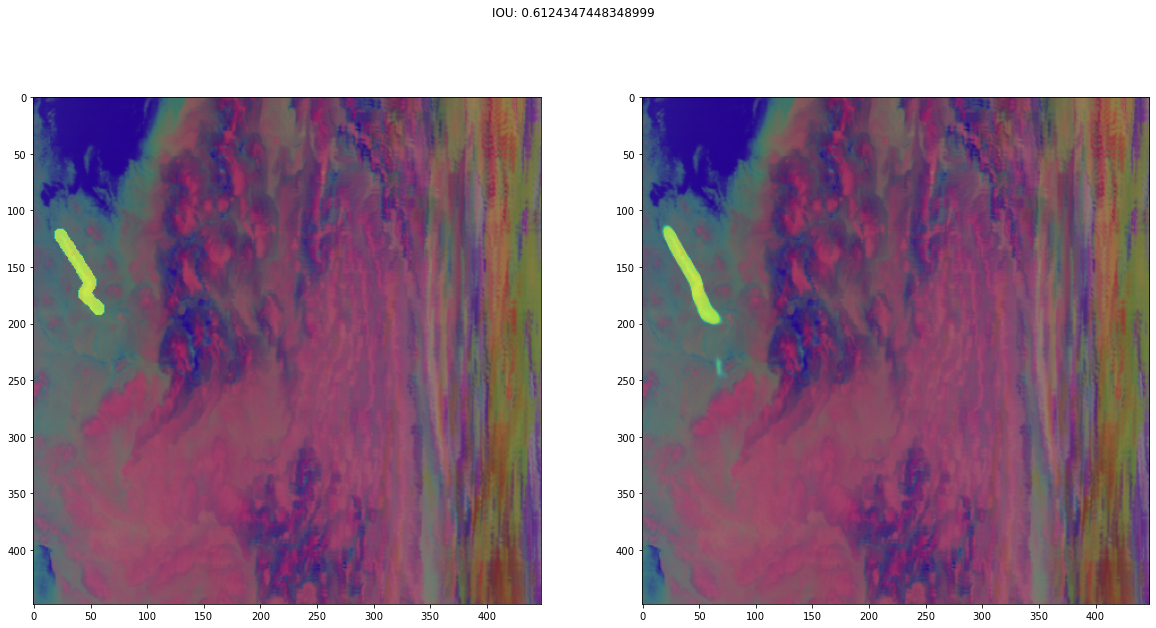

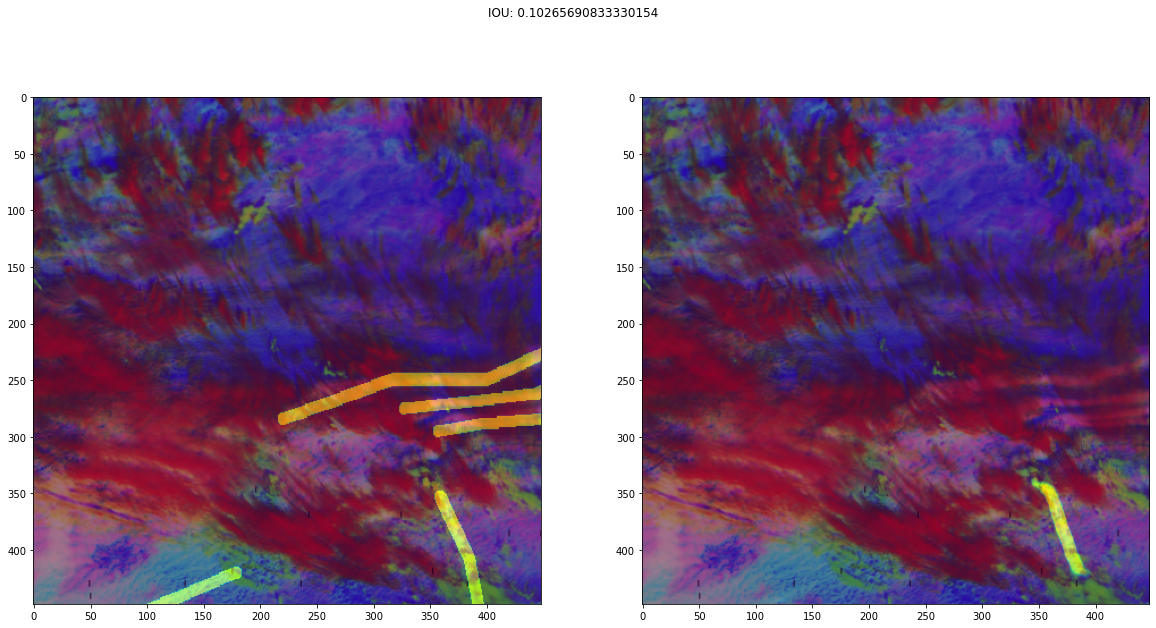

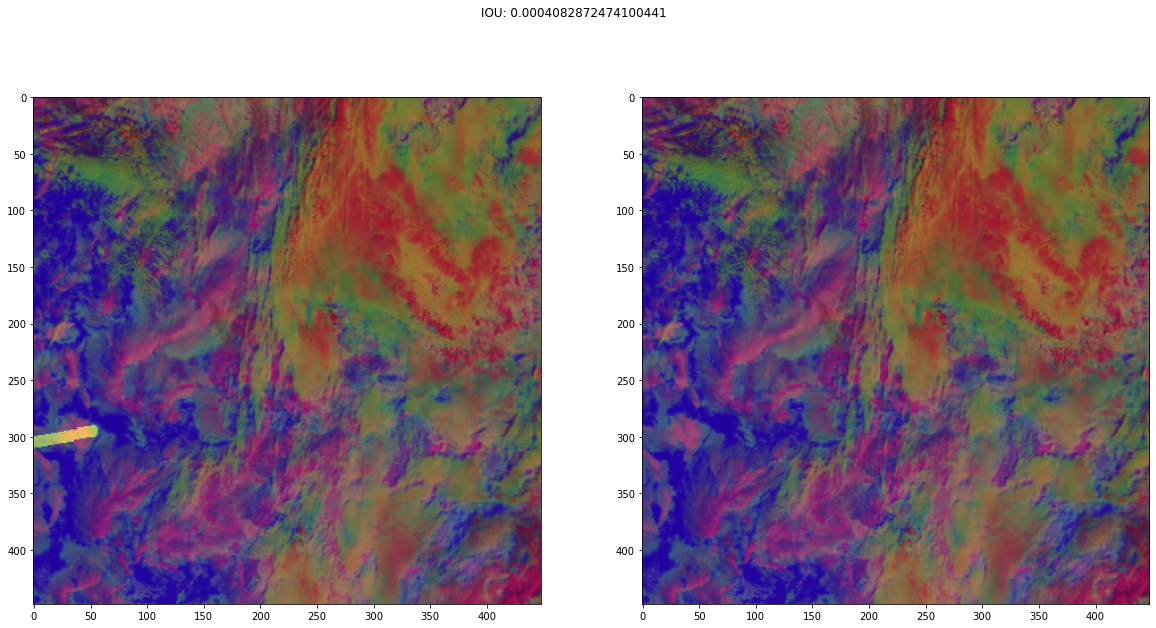

In [5]:
image_dir = model_dir + "test_images/"
if not os.path.isdir(image_dir):
    os.mkdir(image_dir)

scores = []
plt.ioff()

for i, (data, mask) in enumerate(test_ds):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.imshow(data, vmin=0., vmax=1.)
    im=ax1.imshow(mask, alpha=0.5, vmin=0, vmax=1)

    pred = tf_predictor(data=data[tf.newaxis, ...])['sigmoid'][..., 0]
    ax2.imshow(data, vmin=0., vmax=1.)
    ax2.imshow(pred[0], alpha=0.5, vmin=0, vmax=1)
    plt.savefig(image_dir + f"{i:04d}.png")
    score = iou_score(mask[np.newaxis,...], pred)
    scores.append(score)
    fig.suptitle(f"IOU: {score}")
    if i % 10 == 0:
        plt.show()
    else:
        plt.close()


In [6]:
print(np.mean(scores))

0.23580132
